In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [6]:
df = pd.read_csv('./Resources/gtt_results.csv')
df.head()


,id,group,sex,bodyweight,timepoint,0,15,30,60,90,120
0,F208,WT,F,22.8,0,122,194,196.0,188.0,186.0,189.0
1,F039,CLOCK,F,26.7,0,188,165,355.0,596.0,218.0,206.0
2,F014,WT,F,25.1,0,182,289,240.0,219.0,205.0,231.0
3,F081,CLOCK,F,26.1,0,183,266,206.0,214.0,246.0,168.0
4,F051,WT,F,29.8,0,141,199,200.0,171.0,181.0,145.0


In [24]:
df.dropna(axis='rows', inplace=True)

In [25]:
#Create data frames for each prediction
df_group = df[['group', 'bodyweight', 'timepoint', '0', '15', '30', '60', '90', '120']]
df_sex = df[['sex', 'bodyweight', 'timepoint', '0', '15', '30', '60', '90', '120']]

## Unsupervised model to identify at clusters

In [26]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['bodyweight', 'timepoint', '0', '15', '30', '60', '90', '120']])
scaled_data

array([[-1.44657587e+00, -1.45839466e+00, -1.12304124e+00, ...,
        -4.91653697e-01, -2.99455526e-01, -2.02903271e-03],
       [-5.81903774e-01, -1.45839466e+00,  5.60719212e-01, ...,
         4.77481906e+00,  1.90052946e-01,  3.11698072e-01],
       [-9.36641044e-01, -1.45839466e+00,  4.07650080e-01, ...,
        -9.15050317e-02, -8.80987106e-03,  7.73061462e-01],
       ...,
       [-5.45571063e-03,  1.46758622e+00, -7.70688388e-02, ...,
        -7.62722147e-01, -9.87826815e-01,  5.33345741e-02],
       [ 2.60597242e-01,  1.46758622e+00, -7.91391455e-01, ...,
        -3.62573482e-01, -1.31186989e-01, -1.68119853e-01],
       [-4.97978694e-02,  1.46758622e+00,  1.17299574e+00, ...,
         3.34459676e-01, -6.99984301e-02, -2.23483460e-01]])

In [28]:
# Initialize PCA model
pca = PCA(n_components=0.90)

# Get two principal components for the iris data.
pca = pca.fit_transform(scaled_data)

#Convert to pd dataframe
pca = pd.DataFrame(pca)
pca.head()

,0,1,2,3,4
0,-1.424693,1.078793,-1.815320,0.666332,-0.871765
1,2.484678,1.403529,-0.808650,0.939940,-1.699220
2,0.378834,1.317219,-1.178750,-0.403195,-0.101924
3,-0.060820,1.392783,-0.976927,-0.134919,0.317033
4,-1.259134,0.839754,-0.993108,1.355011,0.547998


In [43]:
#t-SNE analysis
tsne = TSNE(learning_rate='auto', perplexity=1)

tsne_features_pca = tsne.fit_transform(pca)
tsne_features_raw = tsne.fit_transform(scaled_data)

print(tsne_features_pca.shape)
print(tsne_features_raw.shape)

(191, 2)
(191, 2)


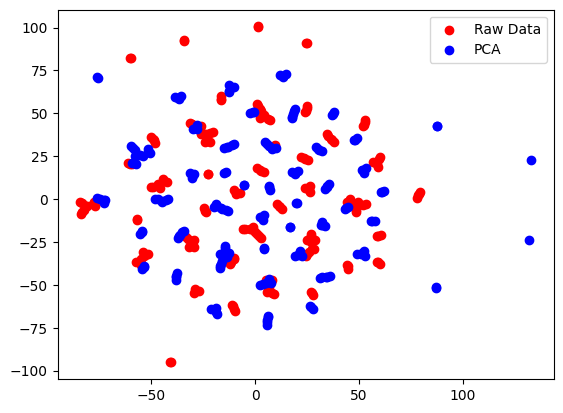

In [44]:
plt.scatter(tsne_features_raw[:,0], tsne_features_raw[:,1], c='red')
plt.scatter(tsne_features_pca[:,0], tsne_features_pca[:,1], c='blue')
plt.legend(['Raw Data', 'PCA'])
plt.show()

## Classifying group

In [13]:
#Assign features
X_g = df_group[['bodyweight', 'timepoint', '0', '15', '30', '60', '90', '120']]
y_g = df.group

# Split the data into X_train, X_test, y_train, y_test
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(X_g, y_g, random_state=1)